In [4]:
import torch
import torchvision
import wandb
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import scipy.io

In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6abf3ddf54b96a2de121a0829fbcaf2d31642561b2b93ab9f8553e00e744e72a
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab\ Notebooks
%ls

/content/drive/MyDrive/Colab Notebooks
Q1.ipynb  train_32x32.mat  train_32x32.zip  wandb/


In [ ]:
wandb.init(project="CV_assignment1_Q1")

loss,█▄▃▄▄▃▃▂▂▃▂▃▂▂▃▂▂▂▂▃▂▃▂▂▁▁▂▂▂▂▁▂▁▂▁▂▁▁▁▂
loss,0.0072


In [ ]:
!unzip train_32x32.zip

Archive:  train_32x32.zip
  inflating: train_32x32.mat         


In [5]:
mat = scipy.io.loadmat('train_32x32.mat')

In [ ]:
print(type(mat))
# print(mat)
print(len(mat))
print(mat.keys())
# print(mat.items())
print(type(mat['X']))
print(mat['X'].shape)
print(mat['y'].shape)
print(mat['__header__'])
print(mat['__version__'])
print(mat['__globals__'])
# print(mat.items())

<class 'dict'>
5
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
<class 'numpy.ndarray'>
(32, 32, 3, 73257)
(73257, 1)
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011'
1.0
[]


<class 'numpy.ndarray'>
(32, 32, 3, 73257)
<class 'numpy.ndarray'>
(73257, 1)
(73257, 32, 32, 3)
Min:  0
Max:  255


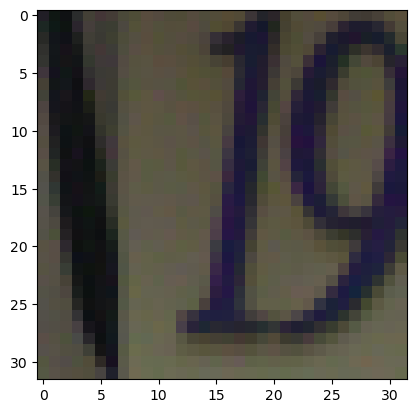

In [ ]:
X = mat['X']
y = mat['y']
print(type(X))
print(X.shape)
print(type(y))
print(y.shape)
# print(type(y[0][0]))
X=np.moveaxis(X, -1, 0)
print(X.shape)
plt.imshow(X[0])
print("Min: ", np.min(X))
print("Max: ", np.max(X))


In [ ]:
class custom(Dataset):
    def __init__(self, data, transform=None):
        self.images = data['X']
        self.labels = data['y']
        self.transform = transform
    def __len__(self):
        return self.images.shape[3]

    def __getitem__(self, idx):
        image=self.images[:,:,:,idx]
        label = self.labels[idx]
        if label[0] == 10:
            label = 0
        else:
            label = label[0]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from torch.utils.data import random_split
data=custom(mat,transform=transforms.Compose([transforms.ToTensor()]))
print(len(data))
print(type(data))
train_data, val_data, test_data = random_split(data, [int(.7*len(data)), int(.9*len(data))-int(.7*len(data)), len(data)-int(.9*len(data))], generator=torch.Generator().manual_seed(42))
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data))
print(type(train_data[0]))
print(type(train_data[0][0]))
print(type(train_data[0][1]))
print(train_data[0][1])

73257
<class '__main__.custom'>
51279
14652
7326
<class 'torch.utils.data.dataset.Subset'>
<class 'tuple'>
<class 'torch.Tensor'>
<class 'numpy.uint8'>
2


In [ ]:
print(type(train_data.dataset.images))

<class 'numpy.ndarray'>


In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
print(len(train_loader))
print(type(train_loader.dataset))

802
<class 'torch.utils.data.dataset.Subset'>


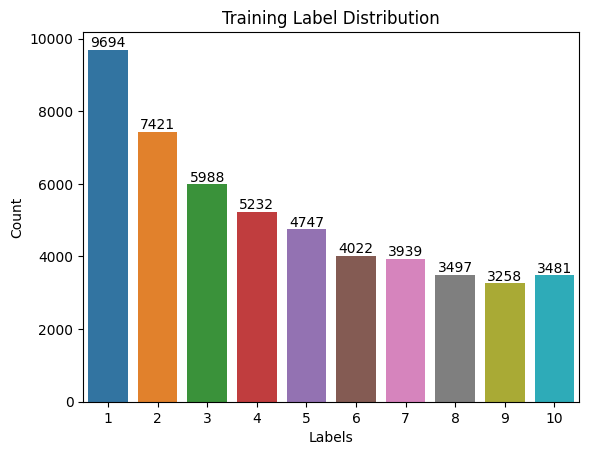

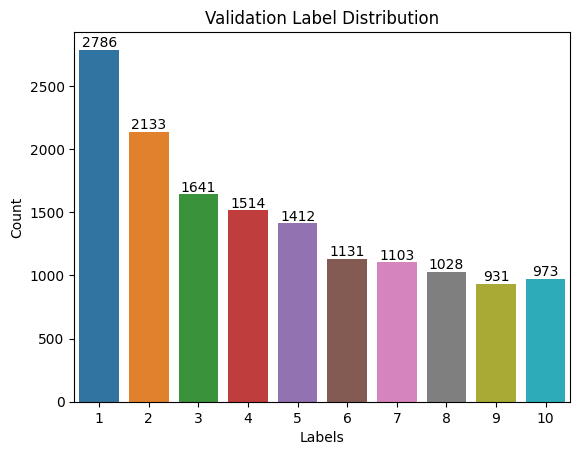

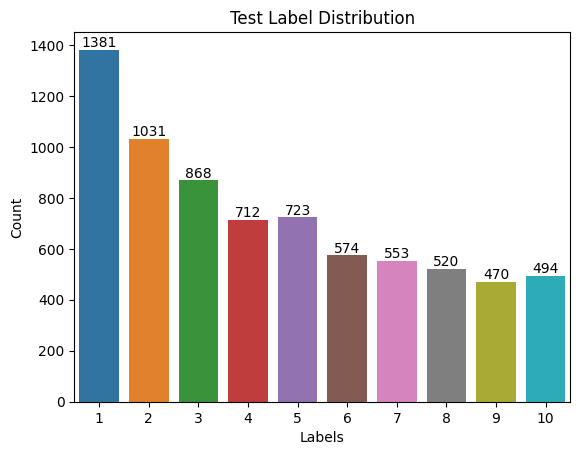

In [ ]:
def plot_bar_graph(loader,title):
    dict={}
    l=loader.dataset[:,1]
    l=l.astype(int)
    for i in l:
        if i in dict:
            dict[i]+=1
        else:
            dict[i]=1
    ax=sns.barplot(x=list(dict.keys()), y=list(dict.values()))
    ax.set(xlabel='Labels', ylabel='Count')
    ax.set_title(title)
    ax.bar_label(ax.containers[0])
    plt.show()

    
plot_bar_graph(train_loader,"Training Label Distribution")
plot_bar_graph(val_loader,"Validation Label Distribution")
plot_bar_graph(test_loader,"Test Label Distribution")

# Q1.2

In [ ]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.con1 = nn.Conv2d(3, 32,kernel_size=3, stride=1, padding=1)
        self.con2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=1)
        self.fc=nn.Linear(32*32*64, 10)
    def forward(self,x):
        return self.fc(torch.flatten(F.relu(self.con2(F.relu(self.con1(x)))),1))

In [ ]:
model=cnn()
print(model)
model.to("cuda")
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

cnn(
  (con1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)


In [ ]:
wandb.watch(model, criterion, log="all", log_freq=100)
for epoch in range(40):
    training_loss=0
    for data in iter(train_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        optimizer.zero_grad()
        output=model(x)
        loss=criterion(output,y)
        loss.backward()
        optimizer.step()
        wandb.log({"loss":loss.item()})
        training_loss+=loss.item()
    print("Epoch: ",epoch," Loss: ",training_loss/len(train_loader))

Epoch:  0  Loss:  2.223730884882577
Epoch:  1  Loss:  2.0041543050597137
Epoch:  2  Loss:  1.2196324353949388
Epoch:  3  Loss:  0.8706577594515094
Epoch:  5  Loss:  0.68386135653516
Epoch:  6  Loss:  0.6395862305773761
Epoch:  7  Loss:  0.6134442677373007
Epoch:  8  Loss:  0.5971916733574392
Epoch:  9  Loss:  0.5773981164518437
Epoch:  10  Loss:  0.5605208190190525
Epoch:  11  Loss:  0.547450689566403
Epoch:  12  Loss:  0.5345426653500209
Epoch:  13  Loss:  0.5217051561039285
Epoch:  14  Loss:  0.5101693595139463
Epoch:  15  Loss:  0.4989051696962846
Epoch:  16  Loss:  0.48996303613272096
Epoch:  17  Loss:  0.4814171576106043
Epoch:  18  Loss:  0.4706470612575883
Epoch:  19  Loss:  0.4626735669381898
Epoch:  20  Loss:  0.4527256051798414
Epoch:  21  Loss:  0.44521105140819217
Epoch:  22  Loss:  0.4363443310235504
Epoch:  23  Loss:  0.428937703371048
Epoch:  24  Loss:  0.41999247031950593
Epoch:  25  Loss:  0.41197028384541634
Epoch:  26  Loss:  0.40569621335687184
Epoch:  27  Loss:  0.

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
model.eval()
correct=0
total=0
predicted_list=[]
with torch.no_grad():
    for data in iter(test_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        output=model(x)
        _,predicted=torch.max(output.data,1)
        predicted_list.extend(predicted)
        total+=y.size(0)
        correct+=(predicted==y).sum().item()
print("Accuracy : ",correct/total)
test_lab=[]
for img,lab in iter(test_loader):
    test_lab.extend(lab)
pred_lab=[]
for i in predicted_list:
    pred_lab.extend(i)
print("F1 Score : ",f1_score(test_lab,pred_lab,average='macro'))
c=confusion_matrix(test_lab,pred_lab)
print("Confusion Matrix :\n ",c)
wandb.log({"Confusion Matrix":wandb.plot.confusion_matrix(probs=None, y_true=test_lab, preds=pred_lab, class_names=None)})

Accuracy :  0.8532623532623532
F1 Score :  0.7885640433632752
Confusion Matrix :
  [[ 43  78  68  65  50  45  44  37  28  22]
 [ 81 278 203 175 145 123 126 112  79  72]
 [ 59 218 145 141 120  93  82  78  49  73]
 [ 56 185 109  92  89  83  68  72  48  54]
 [ 45 161 117  72  76  73  61  76  36  37]
 [ 52 139  85 101  65  56  51  67  31  35]
 [ 36 117  80  73  51  49  43  47  31  32]
 [ 33 114  81  59  65  69  49  34  24  36]
 [ 43  86  67  68  51  38  55  34  38  32]
 [ 25  94  77  53  46  45  33  36  32  26]]


# Q1.3

In [ ]:
model2=torchvision.models.resnet18(pretrained=True)
model2.fc=nn.Linear(model2.fc.in_features,10)
model2.to("cuda")
optimizer2=optim.Adam(model2.parameters(),lr=0.001)
criterion2=nn.CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
wandb.init(project="resnet18")
wandb.watch(model2, criterion2, log="all", log_freq=100)

loss,▃▃▂▃▂▂▂█▅▃▄▃▃▃▃▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▁▂▁▁
loss,0.23901


[]

In [ ]:
for epoch in range(40):
    training_loss=0
    for data in iter(train_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        optimizer2.zero_grad()
        output=model2(x)
        loss=criterion2(output,y)
        loss.backward()
        optimizer2.step()
        wandb.log({"loss":loss.item()})
        training_loss+=loss.item()
    print("Epoch: ",epoch," Loss: ",training_loss/len(train_loader))

Epoch:  0  Loss:  0.8976613628745377
Epoch:  1  Loss:  0.3955819569621003
Epoch:  2  Loss:  0.2944721160897813
Epoch:  3  Loss:  0.23382415772041776
Epoch:  4  Loss:  0.19049941456442387
Epoch:  5  Loss:  0.15590826469122843
Epoch:  6  Loss:  0.12686529748857095
Epoch:  7  Loss:  0.11139837767640849
Epoch:  8  Loss:  0.09254216529113099
Epoch:  9  Loss:  0.0749725254294358
Epoch:  10  Loss:  0.06314013270716975
Epoch:  11  Loss:  0.054518551207170765
Epoch:  12  Loss:  0.04947874439500523
Epoch:  13  Loss:  0.04115947010409275
Epoch:  14  Loss:  0.03659638336788807
Epoch:  15  Loss:  0.03234873846332378
Epoch:  16  Loss:  0.030606816215844164
Epoch:  17  Loss:  0.02897314853730212
Epoch:  18  Loss:  0.03214405104351007
Epoch:  19  Loss:  0.020281399535831003
Epoch:  20  Loss:  0.02577418491910293
Epoch:  21  Loss:  0.020879494879930977
Epoch:  22  Loss:  0.016533842519407004
Epoch:  23  Loss:  0.015213110182076365
Epoch:  24  Loss:  0.01271740530530151
Epoch:  25  Loss:  0.011156602803

In [2]:
model2.eval()
correct=0
total=0
predicted_list=[]
with torch.no_grad():
    for data in iter(test_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        output=model2(x)
        _,predicted=torch.max(output.data,1)
        predicted_list.extend(predicted)
        total+=y.size(0)
        correct+=(predicted==y).sum().item()
print("Accuracy : ",correct/total)
pred_lab=[]
for i in predicted_list:
    pred_lab.extend(i.item())
print("F1 Score : ",f1_score(test_lab,pred_lab,average='macro'))
c=confusion_matrix(test_lab,pred_lab)
print("Confusion Matrix :\n ",c)
wandb.log({"confusion matrix":wandb.plot.confusion_matrix(probs=None, y_true=test_lab, preds=pred_lab, class_names=None)})

Accuracy :  0.9256074256074256
F1 Score :  0.80298252832351688
Confusion Matrix :
  [[ 30 110  68  52  44  53  25  25  40  33]
 [ 95 272 223 153 166 112 116  92  83  82]
 [ 73 199 144 136 103  97  81  84  78  63]
 [ 50 160 115 116  88  81  67  67  52  60]
 [ 57 150 121  78  74  67  62  64  46  35]
 [ 46 128  99  75  84  63  43  50  48  46]
 [ 40  96  78  75  54  56  42  51  26  41]
 [ 30 107  72  82  56  59  40  40  41  37]
 [ 27  96  76  75  51  44  32  37  40  34]
 [ 32  99  63  50  47  46  34  35  33  28]]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


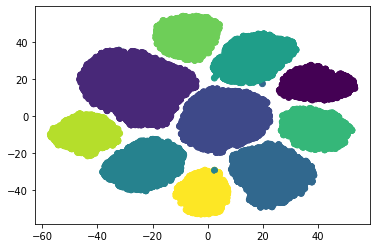

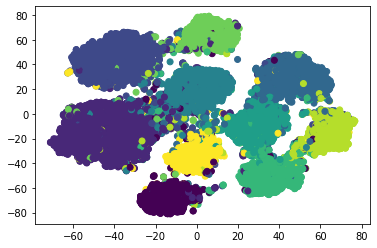

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


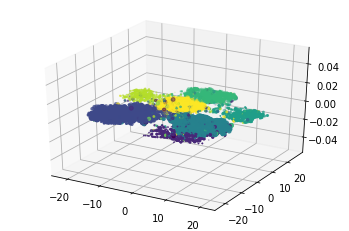

In [ ]:
from sklearn.manifold import TSNE
model2.to("cpu")
train_features=[]
train_labels=[]
val_features=[]
val_labels=[]
model2.eval()
for i in model.parameters():
    i.requires_grad=False
with torch.no_grad():
    for i in range(len(train_data)):
        x,y=train_data[i]
        x=x.unsqueeze(0)
        output=model2(x).squeeze().cpu().numpy()
        train_features.append(output)
        train_labels.append(y)
    for i in range(len(val_data)):
        x,y=val_data[i]
        x=x.unsqueeze(0)
        output=model2(x).squeeze().cpu().numpy()
        val_features.append(output)
        val_labels.append(y)
train_features=np.array(train_features)
train_labels=np.array(train_labels)
val_features=np.array(val_features)
val_labels=np.array(val_labels)
train_features = (train_features-np.mean(train_features,axis=0))/np.std(train_features,axis=0)
val_features = (val_features-np.mean(val_features,axis=0))/np.std(val_features,axis=0)
tsne_2=TSNE()
train_features_2d=tsne_2.fit_transform(train_features)
val_features_2d=tsne_2.fit_transform(val_features)
plt.scatter(train_features_2d[:,0],train_features_2d[:,1],c=train_labels)
plt.show()
plt.scatter(val_features_2d[:,0],val_features_2d[:,1],c=val_labels)
plt.show()
tsne_3=TSNE(n_components=3)
val_features_3d=tsne_3.fit_transform(val_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(val_features_3d[:,0],val_features_3d[:,1],val_features_3d[:,2],c=val_labels)
plt.show()

In [6]:
import albumentations as A
transform1=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Sharpen(p=0.5)
])

In [7]:
class custom_augment(Dataset):
    def __init__(self,dataset,transform=None,isTrain=True):
        self.labels=dataset['y']
        self.image=dataset['X']
        self.transform=transform
        self.isTrain=isTrain
    def __len__(self):
        return self.image.shape[3]

    def __getitem__(self,idx):
        img=self.image[:,:,:,idx]
        if self.isTrain == True:
            temp=transform1(image=img)
            img=temp['image']
        if self.labels[idx][0]==10:
            label=0
        else:
            label=self.labels[idx][0]
        if self.transform:
            img=self.transform(img)
        return img,label

In [8]:
from torch.utils.data import random_split
transform=transforms.Compose([
    transforms.ToTensor()
])
data_aug=custom_augment(mat,transform=transform,isTrain=True)
train_data, val_data, test_data = random_split(data_aug, [int(.7*len(data_aug)), int(.9*len(data_aug))-int(.7*len(data_aug)), len(data_aug)-int(.9*len(data_aug))], generator=torch.Generator().manual_seed(42))
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32,shuffle=True)

In [ ]:
!pip install wandb

In [9]:
wandb.init(project="resnet18")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: ERROR API key must be 40 characters long, yours was 11


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
model2=torchvision.models.resnet18(pretrained=True)
model2.fc=nn.Linear(model2.fc.in_features,10)
model2.to("cuda")
optimizer2=optim.Adam(model2.parameters(),lr=0.001)
criterion2=nn.CrossEntropyLoss()
wandb.watch(model2, criterion2, log="all", log_freq=10)
for epoch in range(40):
    training_loss=0
    for data in iter(train_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        optimizer2.zero_grad()
        output=model2(x)
        loss=criterion2(output,y)
        loss.backward()
        optimizer2.step()
        wandb.log({"loss":loss.item()})
        training_loss+=loss.item()
    print("Epoch: ",epoch," Loss: ",training_loss/len(train_loader))


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch:  0  Loss:  1.0943912257645476
Epoch:  1  Loss:  0.7394927694361729
Epoch:  2  Loss:  0.6291500117004624
Epoch:  3  Loss:  0.5752015924516947
Epoch:  4  Loss:  0.5356643388532357
Epoch:  5  Loss:  0.4957097779845567
Epoch:  6  Loss:  0.47209971087170777
Epoch:  7  Loss:  0.4463212715411885
Epoch:  8  Loss:  0.42708434672074547
Epoch:  9  Loss:  0.41199839374960323
Epoch:  10  Loss:  0.39532545242395833
Epoch:  11  Loss:  0.3797515760677276
Epoch:  12  Loss:  0.36877202772008427
Epoch:  13  Loss:  0.35575855397389816
Epoch:  14  Loss:  0.3453312720464344
Epoch:  15  Loss:  0.3358328282026689
Epoch:  16  Loss:  0.3249755284434657
Epoch:  17  Loss:  0.3148922325877086
Epoch:  18  Loss:  0.3061739420187116
Epoch:  19  Loss:  0.2975721187884928
Epoch:  20  Loss:  0.28884136302400143
Epoch:  21  Loss:  0.2818141157273494
Epoch:  22  Loss:  0.27117150543340096
Epoch:  23  Loss:  0.2640459497371504
Epoch:  24  Loss:  0.2581165056961518
Epoch:  25  Loss:  0.25169469211633994
Epoch:  26  L

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
model2.eval()
correct=0
total=0
predicted_list=[]
with torch.no_grad():
    for data in iter(test_loader):
        x,y=data
        x=x.to("cuda")
        y=y.to("cuda")
        output=model2(x)
        _,predicted=torch.max(output.data,1)
        predicted_list.extend(predicted)
        total+=y.size(0)
        correct+=(predicted==y).sum().item()
print("Accuracy : ",correct/total)
test_lab=[]
for img,lab in iter(test_loader):
    test_lab.extend(lab)
pred_lab=[]
for i in predicted_list:
    pred_lab.extend(i.item())
print("F1 Score : ",f1_score(test_lab,pred_lab,average='macro'))
c=confusion_matrix(test_lab,pred_lab)
print("Confusion Matrix :\n ",c)
wandb.log({"confusion matrix":wandb.plot.confusion_matrix(probs=None, y_true=test_lab, preds=pred_lab, class_names=None)})

Accuracy :  0.8633633633633634
F1 Score :  0.77754602475156112
Confusion Matrix :
  [[ 28  93  76  56  43  47  25  39  39  34]
 [ 87 259 194 156 139 130 111 117 109  92]
 [ 71 206 132 118 108 117  77  79  74  76]
 [ 51 167 125  83  91  81  75  60  64  59]
 [ 40 149 109  72  80  83  54  65  48  54]
 [ 43 129  95  89  62  66  51  51  51  45]
 [ 36  98  68  73  61  67  47  40  41  28]
 [ 48 114  78  47  56  61  41  57  42  20]
 [ 28 103  61  68  54  56  44  32  27  39]
 [ 43  90  55  48  52  43  34  42  29  31]]
